# Scrape VIFF films to Excel

Script to scrape film information from the Vancouver International Film Festival (VIFF) website

In [68]:
from platform import python_version
python_version()

'2.7.11'

In [7]:
# Python script to scrape film information from the
# Vancouver International Film Festival (VIFF) website
# using lxml

import pandas as pd
import numpy as np
import requests
import pickle
from lxml import html

try:
    # For Python 3
    from urllib.parse import urlparse
except ImportError:
    # For Python 2
    from urlparse import urlparse

# build the lxml tree from the chosen website
# Used this as guide:
# https://docs.python-guide.org/scenarios/scrape/

# Enter the base URL where the A-Z list of films is here (from
# the viff.org home page find the 'Search by Title' option):
start_page = "https://www.viff.org/Online/default.asp?" \
             "doWork::WScontent::loadArticle=Load&BOparam::" \
             "WScontent::loadArticle::" \
             "article_id=D5FA11B0-61FD-4217-AAF7-1FC44D897DA1"

start_page_parse_result = urlparse(start_page)
start_page_parse_result

ParseResult(scheme='https', netloc='www.viff.org', path='/Online/default.asp', params='', query='doWork::WScontent::loadArticle=Load&BOparam::WScontent::loadArticle::article_id=D5FA11B0-61FD-4217-AAF7-1FC44D897DA1', fragment='')

In [8]:
page = requests.get(start_page_parse_result.geturl())
tree = html.fromstring(page.text)

In [9]:
# Now extract the information we want

# Get a list of URLs to the VIFF pages of each film
film_elements = tree.xpath('/html/body//div[@class="article-container main-article-body"]//div/a')
film_page_links = {
    el.text.strip(): el.attrib['href'] for el in film_elements
}

print("Found links for %d film pages." % len(film_page_links))

Found links for 355 film pages.


In [11]:
def convert_link_to_url(link, scheme=start_page_parse_result.scheme,
                        netloc=start_page_parse_result.netloc,
                        path=start_page_parse_result.path):
    
    """Converts a relative link such as 'default.asp' into an absolute url
    such as 'https://www.viff.org/Online/default.asp' using the scheme,
    netloc, and path specified."""
    
    parse_result = urlparse(link)

    if parse_result.netloc is '':
        parse_result = parse_result._replace(netloc=netloc)
    if parse_result.scheme is '':
        parse_result = parse_result._replace(scheme=scheme)
    if start_page_parse_result.path.endswith(parse_result.path):
        parse_result = parse_result._replace(path=path)
    
    return parse_result.geturl()

def get_page_lxml_tree(url):
    """Request page from url and convert contents into lxml tree"""

    page = requests.get(url)

    return html.fromstring(page.content)

In [6]:
# Prepare dictionary to collect the film information
year = pd.datetime.now().date().year
data_filename = "viff_data_%d.pickle" % year
try:
    with open("viff_data_%d.pickle" % year, 'rb') as f:
        films = pickle.load(f)
except:
    films = {}
else:
    print("Data from %d films found in data file." % len(films))

Data from 10 films found in data file.


In [7]:
# Now load each film page and extract the information we are looking for

# Set number of films to parse each time (None for all)
batch = 10

already_done = list(films.keys())
total_count = len(films)

print("\nReading information on each film")

for title, link in film_page_links.items():
    
    # Skip if already in films dictionary
    if title in already_done:
        continue

    # Convert link to a complete url
    page_url = convert_link_to_url(link)

    # Request page and convert contents to lxml tree
    film_page_tree = get_page_lxml_tree(page_url)

    # Get film title (xpath: '//*[@class="movie-title"]')
    try:
        film_title = film_page_tree.find('.//h1[@class="movie-title"]').text.strip()
    except:
        print("WARNING: Getting title for film '%s' failed -> Skipped." % film_title)
        continue

    # Get film information
    film_info = {}
    try:
        film_information_elements = film_page_tree.find('.//div[@class="movie-information"]').getchildren()
    except:
        print("WARNING: Getting information for film '%s' failed." % film_title)
    else:
        # Put film information into a dictionary
        labels = ['Director', 'Year:', 'Country of Origin:', 
                  'Running Time:', 'Language:']
        for e in film_information_elements:
            text = e.text_content().strip()

            for label in labels:
                if text[0:len(label)] == label:

                    # remove ':' if there is one
                    if label[-1] == ':':
                        key = label[0:-1]
                    else:
                        key = label

                    film_info[key] = text[text.find(label) + len(label):].strip()

    # Get film description
    try:
        film_description = film_page_tree.find('.//div[@class="movie-description"]').text_content().strip()
    except:
        film_description = None
        print("WARNING: Description for film '%s' missing." % film_title)

    print(" %4d: %s -> %d info records found." % (total_count, film_title, len(film_info)))

    films[film_title] = {
        'Information': film_info,
        'Description': film_description
    }

    total_count += 1
    if batch:
        batch -= 1
        if batch < 1:
            break



Reading information on each film
   10: At War -> 5 info records found.
   11: Where -> 4 info records found.
   12: The Favourite -> 4 info records found.
   13: The Hymns of Muscovy -> 5 info records found.
   14: ante mis ojos -> 5 info records found.
   15: The Front Runner -> 4 info records found.
   16: Prawn -> 4 info records found.
   17: Colette -> 4 info records found.
   18: Daughter of Mine -> 5 info records found.
   19: Birds of Passage -> 5 info records found.


In [8]:
print("\nInformation on %d films now acquired." % len(films))

# Now save the film records to an excel file
with open(data_filename, 'wb') as f:
    pickle.dump(films, f)
print("Results saved to file '%s'." % data_filename)


Information on 20 films now acquired.
Results saved to file 'viff_data_2018.pickle'.


In [17]:
# Move data into pandas dataframe
columns = set()
data = dict()

for film in films: 
    for key in films[film]['Information']:
        columns = columns.union([key])

for column in columns:
    data[column] = []

data['Description'] = []
data['Title'] = []

for film in films:
    data['Title'].append(film)
    for column in columns:
        try:
            data[column].append(films[film]['Information'][column])
        except KeyError:
            data[column].append(np.nan)
    data['Description'].append(films[film]['Description'])

# Dataframe from data
df = pd.DataFrame(data=data)

# Re-order so title column is first
new_columns = list(df.columns.values)
new_columns.remove('Title')
new_columns = ['Title'] + new_columns
df = df[new_columns]

df.head()

In [19]:
excel_output_filename = "VIFF%d_all.xls" % year
print("Saving results to Excel file '%s'" % excel_output_filename)

# Save to excel
df.to_excel(excel_output_filename)

Saving results to Excel file 'VIFF2018_all.xls'


## Alternative script using Selenium to load page information

This version is able to read movie screening times

In [1]:
# Python script to scrape film information from the
# Vancouver International Film Festival (VIFF) website
# using Selenium

import pandas as pd
import numpy as np
import requests
import pickle
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

try:
    # For Python 3
    from urllib.parse import urlparse
except ImportError:
    # For Python 2
    from urlparse import urlparse

print("\n -------------- viff_scrape2.py --------------\n")

print("Scrape information on this year's films from 'https://www.viff.org'")
year = pd.datetime.now().date().year

print("Launching Selenium web-page driver...")
driver = webdriver.Safari()  # Other options include Chrome, Firefox

# Enter the base URL where the A-Z list of films is here (from
# the viff.org home page find the 'Search by Title' option):
start_page_url = "https://www.viff.org/Online/default.asp?" \
                 "doWork::WScontent::loadArticle=Load&BOparam::" \
                 "WScontent::loadArticle::" \
                 "article_id=D5FA11B0-61FD-4217-AAF7-1FC44D897DA1"

start_page_parse_result = urlparse(start_page_url)
start_page_parse_result


 -------------- viff_scrape2.py --------------

Scrape information on this year's films from 'https://www.viff.org'
Launching Selenium web-page driver...


ParseResult(scheme='https', netloc='www.viff.org', path='/Online/default.asp', params='', query='doWork::WScontent::loadArticle=Load&BOparam::WScontent::loadArticle::article_id=D5FA11B0-61FD-4217-AAF7-1FC44D897DA1', fragment='')

In [2]:
print("Opening Viff film list web-page...")
# Open webpage in driver
driver.get(start_page_url)

Opening Viff film list web-page...


In [3]:
# Now extract the information we want

# Get a list of URLs to the VIFF pages of each film
xp = '/html/body//div[@class="article-container main-article-body"]//div/a'
film_link_elements = driver.find_elements_by_xpath(xp)
film_page_links = [
    {'text': el.text.strip(), "href": el.get_attribute('href')} 
    for el in film_link_elements
]
print("Found links for %d film pages." % len(film_page_links))

Found links for 355 film pages.


In [4]:
def convert_link_to_url(link, scheme=start_page_parse_result.scheme,
                        netloc=start_page_parse_result.netloc,
                        path=start_page_parse_result.path):
    """Converts a relative link such as 'default.asp' into an absolute url
    such as 'https://www.viff.org/Online/default.asp' using the scheme,
    netloc, and path specified."""
    
    parse_result = urlparse(link)

    if parse_result.netloc is '':
        parse_result = parse_result._replace(netloc=netloc)
    if parse_result.scheme is '':
        parse_result = parse_result._replace(scheme=scheme)
    if start_page_parse_result.path.endswith(parse_result.path):
        parse_result = parse_result._replace(path=path)
    
    return parse_result.geturl()

def get_page_lxml_tree(url):
    """Request page from url and convert contents into lxml tree"""

    page = requests.get(url)

    return html.fromstring(page.content)

In [5]:
def get_film_details(driver, max_screenings=5):
    """Reads film information from Selenium web-driver."""
    
    # Get movie title
    xp = './/h1[@class="movie-title"]'
    try:
        film_title = driver.find_element_by_xpath(xp).text.strip()
    except:
        print("WARNING: Title for film '%s' not found on page " \
              "-> skipped." % film_title)
        return None

    # Get film information
    film_info = {}
    xp = './/div[@class="movie-information"]/*'
    try:
        film_info_elements = driver.find_elements_by_xpath(xp)
    except:
        print("WARNING: Getting information for film '%s' failed." % film_title)
    else:
        # Put film information into a dictionary
        labels = ['Director', 'Year:', 'Country of Origin:', 
                  'Running Time:', 'Language:']
        for e in film_info_elements:
            text = e.text.strip()

            for label in labels:
                if text[0:len(label)] == label:

                    # remove ':' if there is one
                    if label[-1] == ':':
                        key = label[0:-1]
                    else:
                        key = label

                    film_info[key] = text[text.find(label) + len(label):].strip()
    
    # Get film description
    xp = '//div[@class="movie-description"]'
    try:
        film_description = driver.find_element_by_xpath(xp).text.strip()
    except:
        film_description = None
        print("WARNING: Description for film '%s' missing." % film_title)
    
    # Get screening times
    xp = '//div[@class="movie-tickets"]/div[@name="avWidget"]' \
         '//div[@class="item-description result-box-item-details"]'
    search_result_elements = driver.find_elements_by_xpath(xp)
    screenings = []
    
    if len(search_result_elements) > max_screenings:
        print("WARNING: Film '%s' has more than %d screening times."
              "Only 4 will be saved" % (film_title, max_screenings))

    for element in search_result_elements:
        
        start_date_string = element.find_element_by_class_name('item-start-date') \
                            .find_element_by_class_name('start-date').text
        venue = element.find_element_by_class_name('item-venue').text
        
        screenings.append({
                'Start date': pd.to_datetime(start_date_string),
                'Venue': venue
            })
    
    film_details = {
        'Title': film_title,
        'Information': film_info,
        'Description': film_description,
        'Screenings': screenings
    }
    
    return film_details

In [6]:
# Prepare dictionary to collect the film information
year = pd.datetime.now().date().year
data_filename = "viff_data_%d_2.pickle" % year
try:
    with open(data_filename, 'rb') as f:
        films = pickle.load(f)
except:
    films = {}
else:
    print("Data from %d films found in data file." % len(films))

Data from 355 films found in data file.


In [7]:
# ----------------- MAIN LOOP -----------------
print("loading each film page to extract information...")

# Set number of films to parse each time (None for all)
batch = 10

already_done = list(films.keys())
total_count = len(films)
max_screenings = 3

film_page_links[2]
for page_link in film_page_links:
    
    title, link = page_link['text'], page_link['href']

    # Skip if already in films dictionary
    if title in already_done:
        continue

    # Convert link to a complete url
    page_url = convert_link_to_url(link)
    
    # Get film information
    driver.get(page_url)
    film_details = get_film_details(driver)
    
    if film_details is None:
        # Skip this film
        continue

    if film_details['Title'] != title:
        print("WARNING: Title for film '%s' does not match link." % title)
    
    films[title] = film_details
    print(" %4d: %s" % (total_count, film_details['Title']))

    total_count += 1
    if batch:
        batch -= 1
        if batch < 1:
            break

loading each film page to extract information...


In [8]:
print("\nInformation on %d films now acquired." % len(films))

# Now save the film records to an excel file
with open(data_filename, 'wb') as f:
    pickle.dump(films, f)
print("Results saved to file '%s'." % data_filename)

print("Closing Selenium web-page driver...")
driver.close()


Information on 355 films now acquired.
Results saved to file 'viff_data_2018_2.pickle'.
Closing Selenium web-page driver...


In [9]:
# Move data into pandas dataframe
info_cols = set()
data = dict()

for film in films: 
    for key in films[film]['Information']:
        info_cols = info_cols.union([key])

max_screenings = max([len(details['Screenings']) for 
                      details in films.values()])

date_cols = set(["Screening date %d" % (i + 1) for i in range(max_screenings)])
venue_cols = set(["Screening venue %d" % (i + 1) for i in range(max_screenings)])

# Add an empty list to dictionary for each series expected
for column in info_cols.union(date_cols).union(venue_cols):
    data[column] = []
data['Description'] = []
data['Title'] = []

for film in films:
    data['Title'].append(film)
    for col in info_cols:
        try:
            data[col].append(films[film]['Information'][col])
        except KeyError:
            data[col].append(np.nan)
    data['Description'].append(films[film]['Description'])
    for i, cols in enumerate(zip(date_cols, venue_cols)):
        try:
            data[cols[0]].append(films[film]['Screenings'][i]['Start date'])
            data[cols[1]].append(films[film]['Screenings'][i]['Venue'])
        except IndexError:
            data[cols[0]].append(np.nan)
            data[cols[1]].append(np.nan)

# Dataframe from data
df = pd.DataFrame(data=data)

# Re-order so title column is first
new_columns = list(df.columns.values)
new_columns.remove('Title')
new_columns = ['Title'] + new_columns
df = df[new_columns]

df.head()

,Title,Country of Origin,Description,Director,Language,Running Time,Screening date 1,Screening date 2,Screening date 3,Screening venue 1,Screening venue 2,Screening venue 3,Year
0,Unearthing. In Conversation,Austria,Traversing the intersection of theory and art ...,Belinda Kazeem-Kamiński,NaN,13 mins,2018-10-02 18:15:00,2018-10-07 14:00:00,NaT,Vancity Theatre,Vancity Theatre,NaN,2017
1,Microhabitat,South Korea,"If your rent goes up, do you give up 1) cigare...",Jeon Gowoon,In Korean with English subtitles,106 mins,2018-09-30 18:30:00,2018-10-02 16:00:00,NaT,International Village 9,International Village 9,NaN,2017
2,Winter Flies,Czech Republic,Stand By Me meets Y Tu Mamá También on a stret...,Olmo Omerzu,In Czech with English subtitles,85 mins,2018-10-05 18:45:00,2018-10-11 10:45:00,NaT,SFU Goldcorp,SFU Goldcorp,NaN,2018
3,First Generation,USA,"A teen Vietnamese-American girl, confused by m...",Jeannie Nguyen,NaN,9 mins,2018-10-04 11:00:00,2018-10-07 18:00:00,NaT,International Village 9,International Village 9,NaN,2017
4,Carmine Street Guitars,Canada,"Nestled in Greenwich Village, Carmine Street G...",Ron Mann,NaN,80 mins,2018-10-02 18:15:00,2018-10-07 16:30:00,NaT,Rio Theatre,SFU Goldcorp,NaN,2018


In [10]:
excel_output_filename = "VIFF%d_all_with_dates.xls" % year
print("Saving results to Excel file '%s'" % excel_output_filename)

# Save to excel
df.to_excel(excel_output_filename)

print("Finished.")

Saving results to Excel file 'VIFF2018_all_with_dates.xls'
Finished.


## Do some fun analysis

In [1103]:
# Load films from file
data_filename = "viff_data_%d_2.pickle" % year
try:
    with open(data_filename, 'rb') as f:
        films = pickle.load(f)
except:
    films = {}
len(films)

355

In [1104]:
title_text = ' '.join([film for film in films])

In [1105]:
def count_words(text, exclude_words=None, strip_chars='()-_:[]{}&" '):

    words = text.split()
    word_tally = {}
    for word in words:
        word_lower = word.lower().strip(strip_chars)
        if word_lower:
            word_tally[word_lower] = word_tally.get(word_lower, 0) + 1

    if exclude_words is not None:
        for word in exclude_words:
            if word.lower() in word_tally:
                del(word_tally[word])
    
    return word_tally

In [1106]:
exclude_words = ['my', 'the', 'of', 'a', 'and', 'in', 'is', 'at', 'an', 'you', 'what', 'on', 
                 'la', 'to', 'i', 'it', 'from', 'their', 'are', 'or',
                 '1', '2', '3', 'with', 'as', 'that', 'for', 'by', 'this', 'it', 'has', 
                 'his', 'her', 'he', 'she', 'they', 'our', 'your', 'ours', 'yours', 'but',
                 u'it\u2019s', 'its', 'be', 'was', u'isn\u2019t', 'not', 'into', 'up', 
                 'not', 'have', 'who', 'all', 'also', 'us', 'out', 'so', 'we', 'between', 
                 'while', 'which', 'been', 'these', 'than']
print(', '.join(exclude_words))

my, the, of, a, and, in, is, at, an, you, what, on, la, to, i, it, from, their, are, or, 1, 2, 3, with, as, that, for, by, this, it, has, his, her, he, she, they, our, your, ours, yours, but, it’s, its, be, was, isn’t, not, into, up, not, have, who, all, also, us, out, so, we, between, while, which, been, these, than


In [1107]:
word_tally = count_words(title_text, exclude_words=exclude_words)

In [1108]:
pd.Series(word_tally).sort_values(ascending=False).head(10)

shock             6
waves             6
war               6
house             5
life              4
quantification    4
under             4
trilogy           4
room              4
street            4
dtype: int64

In [1109]:
top10 = pd.Series(word_tally).sort_values(ascending=False).head(10).index.values.tolist()
print(', '.join(top10))

shock, waves, war, house, life, quantification, under, trilogy, room, street


In [1110]:
for word in top10:
    print("\n%s:" % word)
    print(' ' + '\n '.join([film.strip('()-_:[]{} ') for film in films if (word in film.lower())]))


shock:
 Shock Waves: Diary of My Mind
 Shock Waves: The Valley
 Shock Waves: First Name Mathieu
 Shock Waves: Sirius
 Shock Waves: Program 1 & 2
 Shock Waves: Program 3 & 4

waves:
 Shock Waves: Diary of My Mind
 Shock Waves: The Valley
 Shock Waves: First Name Mathieu
 Shock Waves: Sirius
 Shock Waves: Program 1 & 2
 Shock Waves: Program 3 & 4

war:
 At War
 Theatre of War
 Woman at War
 A Private War
 Memoir of War
 Cold War

house:
 A Dreaming House
 Open House
 Julio Iglesias's House
 The Wolf House
 The House That Jack Built

life:
 Another Day of Life
 Bergman - A Year in a Life
 This Mountain Life
 My Life Is a Joke

quantification:
 Quantification Trilogy- Liminals
 Quantification Trilogy
 Quantification Trilogy - Quickeners
 Quantification Trilogy - I Can See Forever

under:
 Under the Viaduct
 Dreaming Under Capitalism + The Washing Society
 Dreaming Under Capitalism
 Under the Silver Lake

trilogy:
 Quantification Trilogy- Liminals
 Quantification Trilogy
 Quantification Tr

In [1111]:
description_text = ' '.join([item['Description'] for item in films.values() if item['Description'] is not None])
len(description_text)

352834

In [1112]:
word_tally = count_words(description_text, exclude_words=exclude_words)

In [1113]:
pd.Series(word_tally).sort_values(ascending=False).head(20)

film        246
one         142
about       130
when        118
through      89
more         89
life         86
new          83
own          82
world        76
can          75
where        73
director     71
two          70
only         61
young        60
how          60
like         59
most         58
first        58
dtype: int64

## Use screening times to build a viewing schedule

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load films from file
year = pd.datetime.now().date().year
data_filename = "viff_data_%d_2.pickle" % year
try:
    with open(data_filename, 'rb') as f:
        films = pickle.load(f)
except:
    films = {}

In [3]:
# Find films based on a word:
word = "Ash"
print('\n'.join([film.strip('()-_:[]{} ') for film in films if (word.lower() in film.lower())]))

Dreaming Under Capitalism + The Washing Society
Ash Is Purest White
The Washing Society


In [4]:
film_duration_allowance = pd.Timedelta('2H')
film_duration_allowance

Timedelta('0 days 02:00:00')

In [5]:
desired_films = {
    1: ['All Good', 'Happy as Lazzaro', 'Cold War', 'Burning', 'The Wild Pear Tree', 
        "It's Boring Here, Pick Me Up", 'Shoplifters', 'Jinpa', 'Daughter of Mine', 'Last Summer'],
    2: ['In the Aisles', 'The Favourite', 'Winter Flies', 'Woman at War', 
        'Sicilian Ghost Story', 'Birds of Passage', 'Ash Is Purest White'],
    3: ['Dovlatov', "Long Day's Journey Into Night", 'Capernaum']
}

In [6]:
selected_films = desired_films[1] + desired_films[2]
n_films = len(selected_films)
n_films

17

In [7]:
selected_film_screenings = {}
for film in selected_films:
    selected_film_screenings[film] = \
        [screening['Start date'] for screening in films[film]['Screenings']]

In [8]:
earliest_start_time = np.min([np.min(screenings) for screenings in selected_film_screenings.values()])
latest_end_time = np.max([np.min(screenings) for screenings in selected_film_screenings.values()]) + film_duration_allowance

earliest_start_time, latest_end_time

(Timestamp('2018-09-27 21:00:00'), Timestamp('2018-10-09 21:00:00'))

In [9]:
full_time_period = pd.date_range(earliest_start_time, latest_end_time, freq='15 min')

In [10]:
film_times = {}
full_time_period = pd.date_range(earliest_start_time, latest_end_time, freq='15 min')
for film in selected_films:
    showing_times = []
    for start_time in selected_film_screenings[film]:
        all_times = pd.Series(False, index=list(full_time_period), dtype=bool)
        all_times[start_time:(start_time + film_duration_allowance)] = True
        showing_times.append(all_times)
    film_times[film] = showing_times
len(film_times)

17

In [11]:
all_film_times = []
index = []

for film in selected_films:
    for i, t in enumerate(film_times[film]):
        all_film_times.append(t)
        index.append((film, i))

selected_film_screening_times = pd.DataFrame(
    all_film_times, 
    index=pd.MultiIndex.from_tuples(index, names=['Film', 'Screening'])
)
selected_film_screening_times.head()

2018-09-27 21:00:00  2018-09-27 21:15:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                            2018-09-27 21:30:00  2018-09-27 21:45:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                            2018-09-27 22:00:00  2018-09-27 22:15:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                            2018-09-27 22:30:00  2018-09-27 22:45:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                            2018-09-27 23:00:00  2018-09-27 23:15:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                                   ...           2018-10-09 18:45:00  \
Film             Screening         ...                                 
All Good         0                 ...                         False   
                 1                 ...                         False   
Happy as Lazzaro 0                 ...                         False   
                 1                 ...                         False   
Cold War         0                 ...                         False   

                            2018-10-09 19:00:00  2018-10-09 19:15:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False                False   

                            2018-10-09 19:30:00  2018-10-09 19:45:00  \
Film             Screening                                             
All Good         0                        False                False   
                 1                        False                False   
Happy as Lazzaro 0                        False                False   
                 1                        False                False   
Cold War         0                        False              

In [37]:
selected_film_screening_times.shape

(34, 1153)

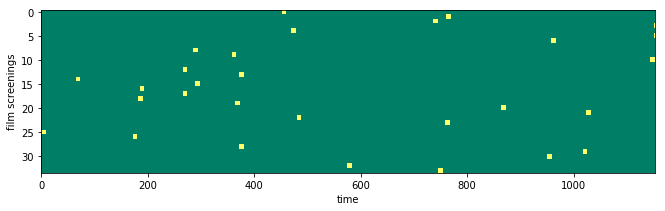

In [36]:
fig, ax = plt.subplots(figsize=(11,3))

plt.imshow(selected_film_screening_times, aspect='auto', cmap='summer')
plt.xlabel('time')
plt.ylabel('film screenings')
plt.show()

In [38]:
n_screenings_per_film = pd.Series([len(selected_film_screenings[film]) for film in selected_films], index=selected_films)
n_screenings_per_film

All Good                        2
Happy as Lazzaro                2
Cold War                        2
Burning                         2
The Wild Pear Tree              2
It's Boring Here, Pick Me Up    2
Shoplifters                     2
Jinpa                           2
Daughter of Mine                2
Last Summer                     2
In the Aisles                   2
The Favourite                   1
Winter Flies                    2
Woman at War                    3
Sicilian Ghost Story            2
Birds of Passage                2
Ash Is Purest White             2
dtype: int64

In [39]:
args = [range(n) for n in n_screenings_per_film]
meshgrids = np.meshgrid(*args)
all_combinations = np.stack([m.flatten() for m in meshgrids]).transpose()
all_combinations.shape

(98304, 17)

In [40]:
all_combinations[0:5, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [42]:
i = 3
combination = zip(selected_films, all_combinations[i, :])
combination

[('All Good', 0),
 ('Happy as Lazzaro', 0),
 ('Cold War', 0),
 ('Burning', 0),
 ('The Wild Pear Tree', 0),
 ("It's Boring Here, Pick Me Up", 0),
 ('Shoplifters', 0),
 ('Jinpa', 0),
 ('Daughter of Mine', 0),
 ('Last Summer', 0),
 ('In the Aisles', 0),
 ('The Favourite', 0),
 ('Winter Flies', 0),
 ('Woman at War', 0),
 ('Sicilian Ghost Story', 0),
 ('Birds of Passage', 1),
 ('Ash Is Purest White', 1)]

In [43]:
selected_film_screening_times.loc[('All Good', 0)].shape

(1153,)

In [44]:
selected_film_screening_times.loc[combination].sum().head(10)

2018-09-27 21:00:00    1
2018-09-27 21:15:00    1
2018-09-27 21:30:00    1
2018-09-27 21:45:00    1
2018-09-27 22:00:00    1
2018-09-27 22:15:00    1
2018-09-27 22:30:00    1
2018-09-27 22:45:00    1
2018-09-27 23:00:00    1
2018-09-27 23:15:00    0
Freq: 15T, dtype: int64

In [46]:
selected_film_screening_times.loc[combination].head()

,,2018-09-27 21:00:00,2018-09-27 21:15:00,2018-09-27 21:30:00,2018-09-27 21:45:00,2018-09-27 22:00:00,2018-09-27 22:15:00,2018-09-27 22:30:00,2018-09-27 22:45:00,2018-09-27 23:00:00,2018-09-27 23:15:00,...,2018-10-09 18:45:00,2018-10-09 19:00:00,2018-10-09 19:15:00,2018-10-09 19:30:00,2018-10-09 19:45:00,2018-10-09 20:00:00,2018-10-09 20:15:00,2018-10-09 20:30:00,2018-10-09 20:45:00,2018-10-09 21:00:00
Film,Screening,,,,,,,,,,,,,,,,,,,,,
All Good,0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Happy as Lazzaro,0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Cold War,0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Burning,0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
The Wild Pear Tree,0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
(selected_film_screening_times.loc[combination].sum() > 1).head(10)

2018-09-27 21:00:00    False
2018-09-27 21:15:00    False
2018-09-27 21:30:00    False
2018-09-27 21:45:00    False
2018-09-27 22:00:00    False
2018-09-27 22:15:00    False
2018-09-27 22:30:00    False
2018-09-27 22:45:00    False
2018-09-27 23:00:00    False
2018-09-27 23:15:00    False
Freq: 15T, dtype: bool

In [48]:
zip(selected_films, combination)

[('All Good', ('All Good', 0)),
 ('Happy as Lazzaro', ('Happy as Lazzaro', 0)),
 ('Cold War', ('Cold War', 0)),
 ('Burning', ('Burning', 0)),
 ('The Wild Pear Tree', ('The Wild Pear Tree', 0)),
 ("It's Boring Here, Pick Me Up", ("It's Boring Here, Pick Me Up", 0)),
 ('Shoplifters', ('Shoplifters', 0)),
 ('Jinpa', ('Jinpa', 0)),
 ('Daughter of Mine', ('Daughter of Mine', 0)),
 ('Last Summer', ('Last Summer', 0)),
 ('In the Aisles', ('In the Aisles', 0)),
 ('The Favourite', ('The Favourite', 0)),
 ('Winter Flies', ('Winter Flies', 0)),
 ('Woman at War', ('Woman at War', 0)),
 ('Sicilian Ghost Story', ('Sicilian Ghost Story', 0)),
 ('Birds of Passage', ('Birds of Passage', 1)),
 ('Ash Is Purest White', ('Ash Is Purest White', 1))]

In [51]:
print("Analyzing all possible combinations...")
possible_combinations = []
n = len(all_combinations)
i = 0
for combination in all_combinations:
    indeces = zip(selected_films, combination)
    # Check for combinations where there is more than one film showing
    # in any 15-min period.
    if (selected_film_screening_times.loc[indeces].sum() > 1).sum() == 0:
        possible_combinations.append(combination)
    i += 1
    if i % 1000 == 0:
        print("%d of %d combinations checked. %d found" % (i, n, len(possible_combinations)))
len(possible_combinations)


Analyzing all possible combinations
1000 of 98304 combinations checked. 22 found
2000 of 98304 combinations checked. 36 found
3000 of 98304 combinations checked. 48 found
4000 of 98304 combinations checked. 48 found
5000 of 98304 combinations checked. 72 found
6000 of 98304 combinations checked. 96 found
7000 of 98304 combinations checked. 120 found
8000 of 98304 combinations checked. 168 found
9000 of 98304 combinations checked. 192 found
10000 of 98304 combinations checked. 192 found
11000 of 98304 combinations checked. 240 found
12000 of 98304 combinations checked. 264 found
13000 of 98304 combinations checked. 288 found
14000 of 98304 combinations checked. 300 found
15000 of 98304 combinations checked. 312 found
16000 of 98304 combinations checked. 312 found
17000 of 98304 combinations checked. 312 found
18000 of 98304 combinations checked. 324 found
19000 of 98304 combinations checked. 336 found
20000 of 98304 combinations checked. 336 found
21000 of 98304 combinations checked. 38

864

In [52]:
possible_combinations_df = pd.DataFrame(possible_combinations, columns=selected_films).head()
possible_combinations_df.head()

,All Good,Happy as Lazzaro,Cold War,Burning,The Wild Pear Tree,"It's Boring Here, Pick Me Up",Shoplifters,Jinpa,Daughter of Mine,Last Summer,In the Aisles,The Favourite,Winter Flies,Woman at War,Sicilian Ghost Story,Birds of Passage,Ash Is Purest White
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,1,0


In [53]:
full_time_period

DatetimeIndex(['2018-09-27 21:00:00', '2018-09-27 21:15:00',
               '2018-09-27 21:30:00', '2018-09-27 21:45:00',
               '2018-09-27 22:00:00', '2018-09-27 22:15:00',
               '2018-09-27 22:30:00', '2018-09-27 22:45:00',
               '2018-09-27 23:00:00', '2018-09-27 23:15:00',
               ...
               '2018-10-09 18:45:00', '2018-10-09 19:00:00',
               '2018-10-09 19:15:00', '2018-10-09 19:30:00',
               '2018-10-09 19:45:00', '2018-10-09 20:00:00',
               '2018-10-09 20:15:00', '2018-10-09 20:30:00',
               '2018-10-09 20:45:00', '2018-10-09 21:00:00'],
              dtype='datetime64[ns]', length=1153, freq='15T')

In [54]:
weekdays = (full_time_period.weekday < 5)
evenings = (full_time_period.hour > 17) & (full_time_period.hour <23)
beer_club_days = (full_time_period.weekday == 1)
weekday_evenings = (weekdays & evenings).astype(int)
weekday_evenings_not_beer_club = ((weekdays & ~beer_club_days) & evenings).astype(int)
weekday_evenings_not_beer_club.shape, weekday_evenings_not_beer_club.sum()

((1153,), 128)

In [55]:
best_days = ['2018-09-29', '2018-09-30', '2018-10-06', '2018-10-07', '2018-10-08']
best_days = (pd.Series(full_time_period.date).isin(pd.to_datetime(best_days).date)).values.astype(int)
best_days.shape, best_days.sum()

((1153,), 480)

In [56]:
time_scores = pd.Series(2*weekday_evenings - weekday_evenings_not_beer_club + 4*best_days, index=full_time_period)
time_scores.sum()

2114

In [57]:
time_scores.min(), time_scores.max()

(0, 5)

In [58]:
data = {
    "Weekday evenings": weekday_evenings,
    "Weekday evenings not beer club": weekday_evenings_not_beer_club,
    "Best days": best_days,
    "Time scores": time_scores
}
time_scores_df = pd.DataFrame(data, index=pd.Index(full_time_period, name="Time"))
time_scores_df.head(10)

,Best days,Time scores,Weekday evenings,Weekday evenings not beer club
Time,,,,
2018-09-27 21:00:00,0,1,1,1
2018-09-27 21:15:00,0,1,1,1
2018-09-27 21:30:00,0,1,1,1
2018-09-27 21:45:00,0,1,1,1
2018-09-27 22:00:00,0,1,1,1
2018-09-27 22:15:00,0,1,1,1
2018-09-27 22:30:00,0,1,1,1
2018-09-27 22:45:00,0,1,1,1
2018-09-27 23:00:00,0,0,0,0


In [59]:
time_scores_df.sort_values(by='Time scores', ascending=False).head()

,Best days,Time scores,Weekday evenings,Weekday evenings not beer club
Time,,,,
2018-10-08 21:15:00,1,5,1,1
2018-10-08 19:00:00,1,5,1,1
2018-10-08 20:30:00,1,5,1,1
2018-10-08 20:45:00,1,5,1,1
2018-10-08 21:00:00,1,5,1,1


In [60]:
len(possible_combinations)

864

In [61]:
scores = []
for i, combination in enumerate(possible_combinations):
    indeces = zip(selected_films, combination)
    scores.append((selected_film_screening_times.loc[indeces].sum()*time_scores).sum())

In [62]:
best_combinations = pd.Series(scores).sort_values(ascending=False)
best_combinations.head(10)

124    331
544    331
62     331
440    331
464    331
14     331
496    331
220    331
434    324
2      324
dtype: int64

In [63]:
summary_df = pd.DataFrame(index=selected_films)
for i in best_combinations.head().index:
    combination = possible_combinations[i]
    data = []
    for film, screening in zip(selected_films, combination):
        data.append(selected_film_screenings[film][screening])
    summary_df[i] = pd.Series(data, index=selected_films)
summary_df

,124,544,62,440,464
All Good,2018-10-02 14:00:00,2018-10-05 19:00:00,2018-10-02 14:00:00,2018-10-05 19:00:00,2018-10-05 19:00:00
Happy as Lazzaro,2018-10-05 13:15:00,2018-10-05 13:15:00,2018-10-05 13:15:00,2018-10-05 13:15:00,2018-10-05 13:15:00
Cold War,2018-10-02 18:30:00,2018-10-02 18:30:00,2018-10-02 18:30:00,2018-10-02 18:30:00,2018-10-02 18:30:00
Burning,2018-10-12 15:00:00,2018-10-12 15:00:00,2018-10-07 20:30:00,2018-10-07 20:30:00,2018-10-07 20:30:00
The Wild Pear Tree,2018-09-30 20:30:00,2018-10-01 14:30:00,2018-10-01 14:30:00,2018-09-30 20:30:00,2018-10-01 14:30:00
"It's Boring Here, Pick Me Up",2018-10-09 19:00:00,2018-10-09 19:00:00,2018-10-09 19:00:00,2018-10-09 19:00:00,2018-10-09 19:00:00
Shoplifters,2018-10-01 18:00:00,2018-10-01 18:00:00,2018-10-01 18:00:00,2018-10-01 18:00:00,2018-10-01 18:00:00
Jinpa,2018-09-28 13:15:00,2018-09-30 21:30:00,2018-09-30 21:30:00,2018-09-28 13:15:00,2018-09-30 21:30:00
Daughter of Mine,2018-09-30 15:30:00,2018-09-30 15:30:00,2018-09-30 15:30:00,2018-09-30 15:30:00,2018-09-30 15:30:00
Last Summer,2018-09-29 18:30:00,2018-09-29 18:30:00,2018-09-29 18:30:00,2018-09-29 18:30:00,2018-09-29 18:30:00


In [65]:
best_pick = 124

In [66]:
summary_df.loc[desired_films[1], best_pick]

All Good                       2018-10-02 14:00:00
Happy as Lazzaro               2018-10-05 13:15:00
Cold War                       2018-10-02 18:30:00
Burning                        2018-10-12 15:00:00
The Wild Pear Tree             2018-09-30 20:30:00
It's Boring Here, Pick Me Up   2018-10-09 19:00:00
Shoplifters                    2018-10-01 18:00:00
Jinpa                          2018-09-28 13:15:00
Daughter of Mine               2018-09-30 15:30:00
Last Summer                    2018-09-29 18:30:00
Name: 124, dtype: datetime64[ns]

In [67]:
summary_df.loc[desired_films[2], best_pick]

In the Aisles          2018-10-06 21:00:00
The Favourite          2018-10-02 21:00:00
Winter Flies           2018-10-05 18:45:00
Woman at War           2018-09-29 16:00:00
Sicilian Ghost Story   2018-10-08 11:15:00
Birds of Passage       2018-10-07 18:30:00
Ash Is Purest White    2018-10-03 20:45:00
Name: 124, dtype: datetime64[ns]